<a href="https://colab.research.google.com/github/KU-Gen-AI-2567/Autoencoder-demo/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder - 01418496 (หมู่เรียน 200)

In [35]:
import tensorflow as tf
import matplotlib.pyplot as plt
import kagglehub
import shutil
import os
tf.__version__

'2.18.0'

In [36]:
import numpy as np
from PIL import Image

### Setting to execute on Processor (GPU or CPU)

In [37]:
gpus = tf.config.list_physical_devices("GPU")
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("Execute on GPU")
else:
    print("Execute on CPU")

Execute on CPU


### Download Dataset

In [38]:
# Download the dataset folder in latest version
if not "dataset" in os.listdir("."):
    path = kagglehub.dataset_download("tongpython/cat-and-dog/version/1")
    print("Path to dataset files:", path)
    shutil.move(path, "./dataset")
    print("Download Dataset Complete")
else:
    print("Download Dataset Already")

Download Dataset Already


## Prepossessing


In [39]:
dataset_path = "./dataset"
for dirpath, dirnames, filenames in os.walk(dataset_path):
    print(f"Path: {dirpath}, Subdirectories: {dirnames}, Files: {len(filenames)}")

Path: ./dataset, Subdirectories: ['test_set', 'training_set'], Files: 0
Path: ./dataset\test_set, Subdirectories: ['test_set'], Files: 0
Path: ./dataset\test_set\test_set, Subdirectories: ['cats', 'dogs'], Files: 0
Path: ./dataset\test_set\test_set\cats, Subdirectories: [], Files: 1012
Path: ./dataset\test_set\test_set\dogs, Subdirectories: [], Files: 1013
Path: ./dataset\training_set, Subdirectories: ['training_set'], Files: 0
Path: ./dataset\training_set\training_set, Subdirectories: ['cats', 'dogs'], Files: 0
Path: ./dataset\training_set\training_set\cats, Subdirectories: [], Files: 4001
Path: ./dataset\training_set\training_set\dogs, Subdirectories: [], Files: 4006


In [40]:
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0  # Normalize pixel values to [0, 1]
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.0)
    return imgs

def to_image(img):
    img = np.squeeze(img)
    return Image.fromarray(np.uint8(img * 255))

In [41]:
import cv2
def dataset_to_numpy_and_preprocess(dataset):
    images, labels = [], []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    imgs = np.concatenate(images)
    lbls = np.concatenate(labels)
    return preprocess(imgs), lbls

def change_gray_images(images):
    gray_images = []
    for image in images:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_images.append(image)

    gray_images = np.array(gray_images)
    gray_images = gray_images[..., np.newaxis]
    # gray_images = np.repeat(gray_images[:, :, :, np.newaxis], 3, axis=3)  # Repeat across the 3rd axis
    return gray_images

In [42]:
train_dir = "./dataset/training_set/training_set"
test_dir = "./dataset/test_set/test_set"

In [43]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(50, 50),  # Resize images
    batch_size=32,
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(50, 50),
    batch_size=32,
)

X_train, y_train = dataset_to_numpy_and_preprocess(train_dataset)
X_test, y_test = dataset_to_numpy_and_preprocess(test_dataset)
X_train_gray = change_gray_images(X_train)
X_test_gray = change_gray_images(X_test)
del train_dataset
del test_dataset

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


In [44]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8005, 54, 54, 3)
y_train shape: (8005,)
X_test shape: (2023, 54, 54, 3)
y_test shape: (2023,)


In [45]:
print(f"X_train_gray: {X_train_gray.shape}")
print(f"X_test_gray: {X_test_gray.shape}")
SHAPE = X_train_gray.shape[1:]
print(f"New Shape: {SHAPE}")

X_train_gray: (8005, 54, 54, 1)
X_test_gray: (2023, 54, 54, 1)
New Shape: (54, 54, 1)


In [46]:
noise_factor = 0.2
X_train_noisy = X_train_gray + noise_factor * tf.random.normal(shape=X_train_gray.shape)
X_test_noisy = X_test_gray + noise_factor * tf.random.normal(shape=X_test_gray.shape)

X_train_noisy = tf.clip_by_value(X_train_noisy, clip_value_min=0., clip_value_max=1.)
X_test_noisy = tf.clip_by_value(X_test_noisy, clip_value_min=0., clip_value_max=1.)

In [47]:
print(f"X train Noisy: {X_train_noisy.shape}")
print(f"X test Noisy: {X_test_noisy.shape}")

X train Noisy: (8005, 54, 54, 1)
X test Noisy: (2023, 54, 54, 1)


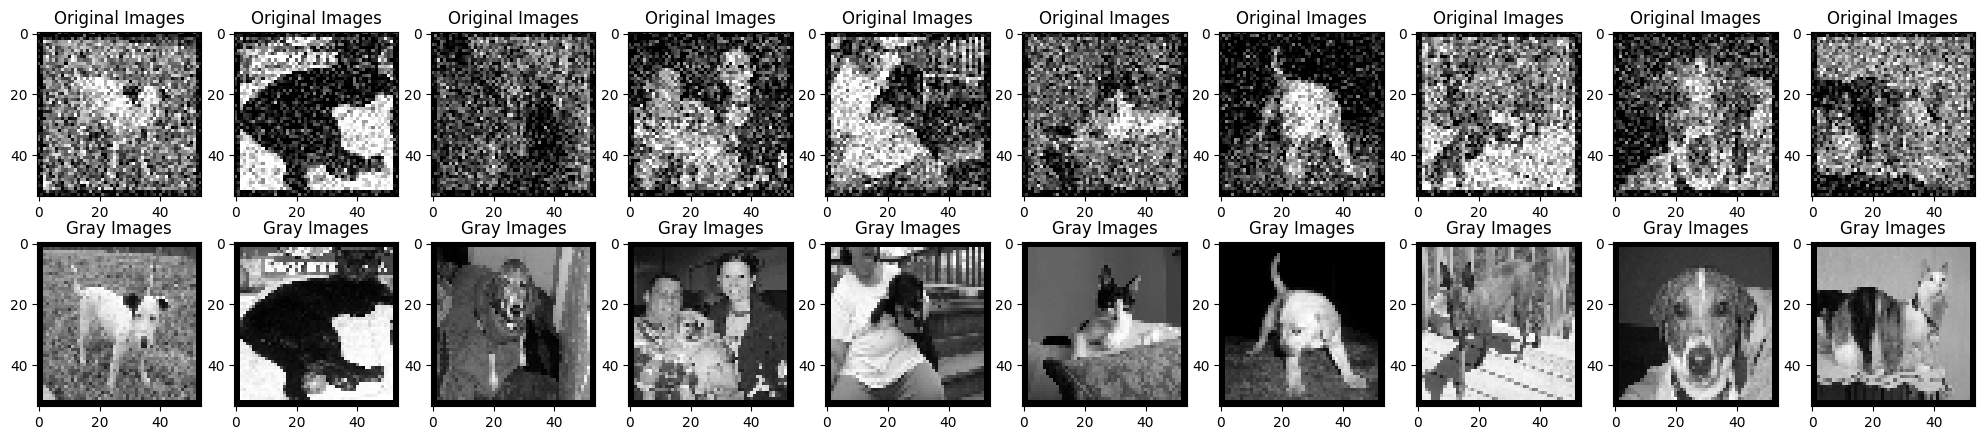

In [48]:
num_images = 10
fig = plt.figure(figsize=(25, 5))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train_noisy[i], cmap='gray')
    plt.title("Original Images")

    plt.subplot(2, 10, i+1+num_images)
    plt.imshow(X_train_gray[i], cmap='gray')
    plt.title("Gray Images")

### Create Model by using function API

In [59]:
from tensorflow.keras import models, layers, losses, activations, optimizers
import tensorflow.keras.backend as K

LATENT_DIM = 1000

# Encoder Model
encoder_input = layers.Input(shape=SHAPE, name="Encoder_Input")

x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu, strides=2)(encoder_input)
x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu)(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu)(x)
# encoder_output = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu, name='Encoder_Output')(x)
shape_before_flatten = K.int_shape(x)[1:]
# shape_before_flatten = K.int_shape(encoder_output)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(LATENT_DIM, activation=activations.relu, name="Encoder_Output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Encoder_Input (InputLayer)      │ (None, 54, 54, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 27, 27, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 27, 27, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 27, 27, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 23328)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Output (Dense)          │ (None, 1000)           │    23,329,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,338,584 (89.03 MB)

 Trainable params: 23,338,584 (89.03 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Decoder Model
decoder_input = layers.Input(shape=(LATENT_DIM,), name="Decoder_Input")
x = layers.Dense(tf.math.reduce_prod(shape_before_flatten).numpy(), activation=activations.relu)(decoder_input)
x = layers.Reshape(shape_before_flatten)(x)

# decoder_input = layers.Input(shape=shape_before_flatten, name="Decoder_Input")

x = layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu)(x)
# x = layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu)(decoder_input)
x = layers.Conv2DTranspose(filters=16, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu)(x)
x = layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu, strides=2)(x)

decoder_output = layers.Conv2D(filters=SHAPE[-1], kernel_size=(2, 2), padding='same', activation=activations.sigmoid, name="Decoder_Output")(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Decoder_Input (InputLayer)      │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 23328)          │    23,351,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 27, 27, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_17             │ (None, 27, 27, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_18             │ (None, 27, 27, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_19             │ (None, 54, 54, 32)     │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_Output (Conv2D)         │ (None, 54, 54, 1)      │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,369,969 (89.15 MB)

 Trainable params: 23,369,969 (89.15 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Encoder_Input (InputLayer)      │ (None, 54, 54, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 27, 27, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 27, 27, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 27, 27, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 23328)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Output (Dense)          │ (None, 1000)           │    23,329,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_13 (Functional)      │ (None, 54, 54, 1)      │    23,369,969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,708,553 (178.18 MB)

 Trainable params: 46,708,553 (178.18 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
EPOCH = 10
BATCH_SIZE = 100

autoencoder.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=losses.MeanAbsoluteError)
autoencoder.fit(X_train_noisy, X_train_gray, epochs=EPOCH, validation_data=(X_test_noisy, X_test_gray), batch_size=BATCH_SIZE)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 38s 448ms/step - loss: 0.2039 - val_loss: 0.1261
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 37s 462ms/step - loss: 0.1154 - val_loss: 0.0967
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 37s 453ms/step - loss: 0.0927 - val_loss: 0.0873
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 37s 456ms/step - loss: 0.0850 - val_loss: 0.0832
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 37s 450ms/step - loss: 0.0813 - val_loss: 0.0799
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 36s 442ms/step - loss: 0.0780 - val_loss: 0.0786
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 36s 440ms/step - loss: 0.0751 - val_loss: 0.0757
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 36s 446ms/step - loss: 0.0727 - val_loss: 0.0740
Epoch 9/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 37s 452ms/step - loss: 0.0706 - val_loss: 0.0744
Epoch 10/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 37s 458ms/step - loss: 0.0696 - val_loss: 0.0729


In [63]:
prediction = autoencoder.predict(X_test_noisy)

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


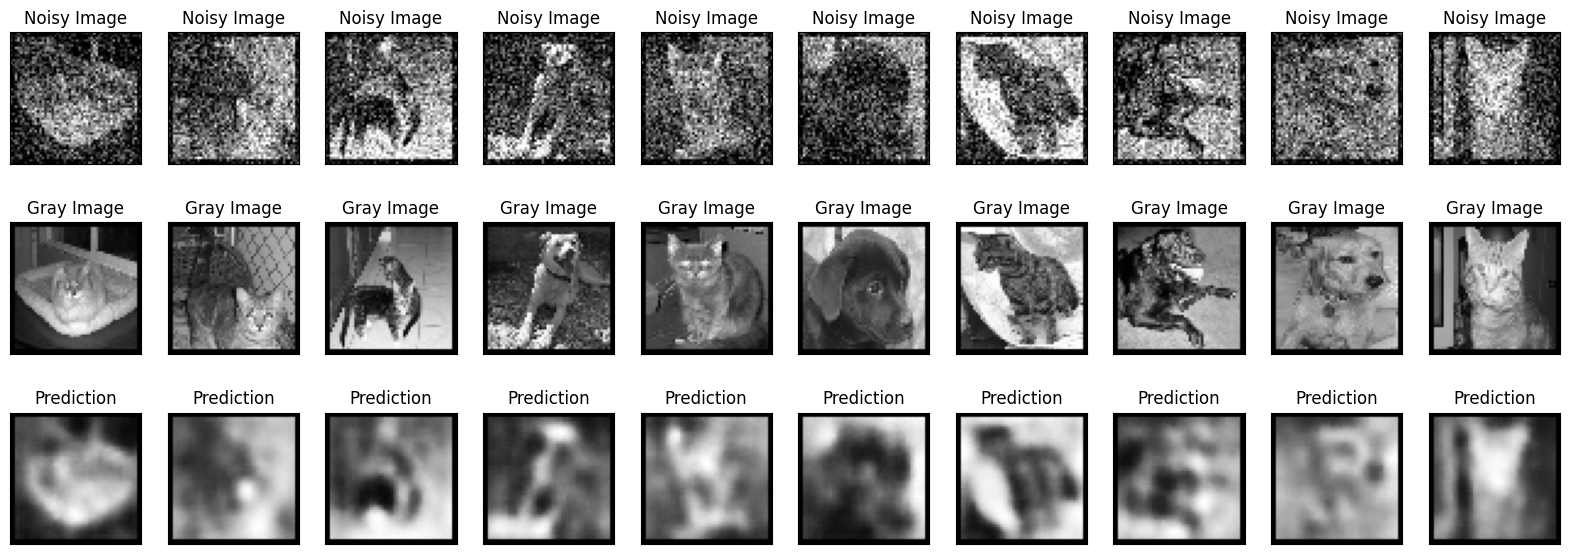

In [88]:
n = 10
plt.figure(figsize=(20, 7))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test_noisy[i], cmap='gray')
    plt.title("Noisy Image")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(X_test_gray[i], cmap='gray')
    plt.title("Gray Image")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i+1+n+n)
    plt.imshow(prediction[i], cmap='gray')
    plt.title("Prediction")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [89]:
encoder_imgs = encoder.predict(X_test_gray)

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


Text(0.5, 0, 'Z')

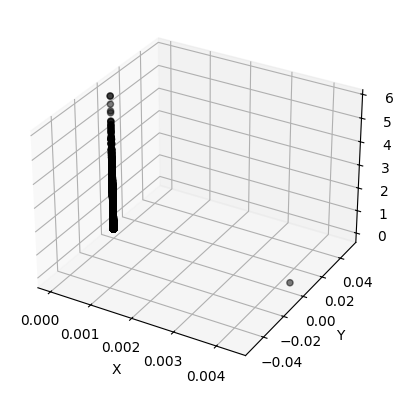

In [97]:
ax = plt.figure().add_subplot(projection='3d')
x = encoder_imgs[:, 1]
y = encoder_imgs[:, 2]
z = encoder_imgs[:, 3]
ax.scatter(x, y, z, alpha=0.5, c='black')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

Text(0.5, 0, 'Z')

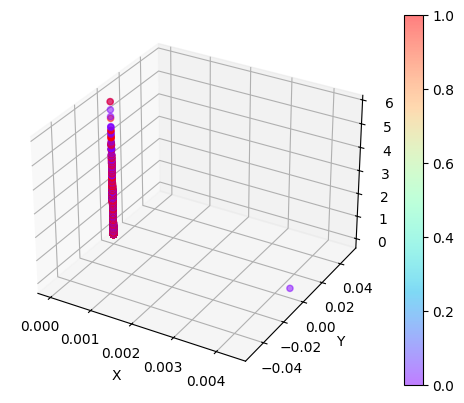

In [104]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x = encoder_imgs[:, 1]
y = encoder_imgs[:, 2]
z = encoder_imgs[:, 3]
p = ax.scatter(x, y, z, alpha=0.5, c=y_test, cmap='rainbow')
fig.colorbar(p)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")